In [1]:
dir_data = '../data/skin-cancer'
dir_ckpt = './outputs/ckpt'
dir_figure = './outputs/figures'
dir_target = './outputs/img_to_be_labeled'

num_seeds = 30
method = 'betti-curve'
n_bins = 100
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

input_shape = {'img': (28, 28, 1), 'tda': (n_bins, 2)}
n_classes = 7


In [2]:
import sys

sys.path.append('../')

from cnntdanet.utils import seed_all
from cnntdanet.tda import get_tda_pipeline
from cnntdanet.models import get_cnn_net, get_cnn_tda_net
from cnntdanet.gradcam import GradCAMOnCNN, GradCAMOnCNNTDANet

import os
import gc
import json
import labelme
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

In [3]:
test_indices = os.listdir(dir_target)
test_indices = set(map(lambda x: int(x.split('_')[0]), test_indices))
test_indices = list(test_indices)
test_indices = sorted(test_indices)
print(test_indices)

[112, 118, 240, 295, 352, 431, 450, 493, 762, 1264, 1356, 1448, 1584, 1652, 1820, 1842, 1986, 2053, 2086, 2087, 2102, 2136, 2173, 2333, 2536, 2545, 2776, 2786, 2937, 3149, 3238, 3273, 3620, 3632, 3732, 3794, 3945, 4069, 4121, 4584, 4705, 4783, 4919, 4923, 5144, 5282, 5306, 5399, 5624, 5648, 5716, 5720, 5977, 5990, 6064, 6081, 6365, 6506, 6693, 6782, 6787, 6791, 6808, 6839, 6914, 7054, 7313, 7417, 7426, 7432, 7630, 7787, 7870, 7911, 8057, 8126, 8172, 8176, 8498, 8499, 8685, 8757, 8807, 8920, 8991, 8996, 9185, 9189, 9198, 9375, 9408, 9470, 9571, 9627, 9696, 9804, 9859, 9954, 9991, 10002]


In [4]:
# Preparing dataset
df = pd.read_csv(os.path.join(dir_data, 'hmnist_28_28_L.csv'))

X = df.drop('label', axis=1).values.reshape((-1, *input_shape['img']))
y = df['label'].values

X = X.astype(np.float32)
X /= 255.0

y = y.astype(np.int64)
y = tf.keras.utils.to_categorical(y, n_classes)

## TDA features
pipeline = get_tda_pipeline(method=method, n_bins=n_bins)

X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

In [5]:
# Splitting data
train_indices = np.setdiff1d(np.arange(len(X)), test_indices)

In [6]:
def iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    if intersection == 0:
        return 0.0
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union

In [7]:
results = {'cnn': [], 'cnn_tda': []}
for seed in range(num_seeds):
    # Set seed
    seed_all(seed)
    
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
    X_img_test,  X_tda_test,  y_test  = X[test_indices],  X_tda[test_indices],  y[test_indices]

    # Train CNN
    cnn = get_cnn_net(input_shape=input_shape['img'], n_classes=n_classes)
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    cnn.fit(
        X_img_train, y_train,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        epochs=20,
        verbose=False
    )

    # Train CNN-TDA Net
    cnn_tda = get_cnn_tda_net(method=method, input_shape=input_shape, n_classes=n_classes)
    cnn_tda.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    cnn_tda.fit(
        [X_img_train, X_tda_train], y_train,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        epochs=20,
        verbose=False
    )

    # Grad-CAM analysis
    gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_3')
    gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_8', global_layer_name='conv1d_8')

    fpath_list = glob(os.path.join(dir_target, '*.npy'))
    for fpath in fpath_list:
        name = fpath.split('/')[-1]
        name = name.split('.')[0]
        idx, label = name.split('_')
        idx, label = map(int, [idx, label])

        img  = X[idx:idx+1]
        tda  = X_tda[idx:idx+1]
        mask = np.load(fpath)
        mask = mask.astype(bool)

        gradcam_cnn_tda.to_heatmap([img, tda], true_label=label)
        gradcam_cnn.to_heatmap(img, true_label=label)

        heatmap_cnn = gradcam_cnn._cache['heatmap'][0][:, :, 0] / 255.0
        heatmap_cnn_tda = gradcam_cnn_tda._cache['heatmap'][0][:, :, 0] / 255.0

        scores_cnn = []
        scores_cnn_tda = []
        for threshold in thresholds:
            mask_cnn = (heatmap_cnn > threshold).astype(bool)
            mask_cnn_tda = (heatmap_cnn_tda > threshold).astype(bool)

            scores_cnn.append(iou(mask, mask_cnn))
            scores_cnn_tda.append(iou(mask, mask_cnn_tda))

        results['cnn'].append(scores_cnn)
        results['cnn_tda'].append(scores_cnn_tda)

        tf.keras.backend.clear_session()
        gc.collect()
print('CNN localization: ', np.mean(results['cnn'], axis=0))
print('CNN-TDA Net localization: ', np.mean(results['cnn_tda'], axis=0))

2022-11-01 13:44:04.917677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


CNN localization:  [0.1943079  0.18319426 0.1658102  0.14358649 0.11628947 0.09393286]
CNN-TDA Net localization:  [0.23887543 0.251468   0.25929819 0.24253394 0.21105443 0.17880733]


In [8]:
index = np.repeat(thresholds, [3000, 3000, 3000, 3000, 3000, 3000]).reshape((-1, 1))
result_cnn = np.array(results['cnn']).T.reshape((-1, 1))
result_cnn_tda =  np.array(results['cnn_tda']).T.reshape((-1, 1))
ret = pd.DataFrame(np.concatenate((index, result_cnn, result_cnn_tda), axis=1))
ret.columns = ['threshold', 'cnn', 'cnn_tda']

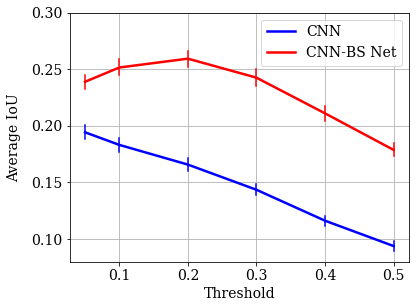

In [10]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.figure(figsize=(6, 4.5))
sns.lineplot(data=ret, x='threshold', y='cnn', markers=True, linewidth=2.5, err_style="bars", color='blue', label='CNN')
sns.lineplot(data=ret, x='threshold', y='cnn_tda', markers=True, linewidth=2.5, err_style="bars", color='red', label='CNN-BS Net')
plt.grid()
plt.legend(loc=1)
plt.ylim(0.08, 0.30)
plt.xlabel('Threshold')
plt.ylabel('Average IoU', labelpad=10)
plt.tight_layout()
plt.savefig(os.path.join(dir_figure, 'iouplot.pdf'), dpi=200)
plt.show()